In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_csv('S02-hw-dataset.csv')

# Первичный анализ данных

In [5]:
df.head()

,user_id,age,country,purchases,revenue
0,1,25,FR,7,749
1,2,24,RU,5,1115
2,3,52,FR,7,399
3,4,31,RU,6,654
4,5,,DE,6,1296


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     41 non-null     int64 
 1    age        41 non-null     object
 2    country    41 non-null     object
 3    purchases  41 non-null     int64 
 4    revenue    41 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.7+ KB


In [7]:
df.columns.tolist()

['user_id', ' age', ' country', ' purchases', ' revenue']

In [8]:
# Исправим названия столбцов, удалив пробел в начале у признаков age, country, purchases, revenue
df.columns = ['user_id', 'age', 'country', 'purchases', 'revenue']

In [9]:
# Переведем значения признака age из object в int64
df['age'] = pd.to_numeric(df['age'], errors='coerce') # Параметр errors='coerce' преобразует некорректные значения в NaN

In [10]:
df.describe()

,user_id,age,purchases,revenue
count,41.00,39.00,41.00,41.00
mean,20.24,36.51,4.83,820.05
std,11.66,18.30,2.71,613.13
min,1.00,5.00,-1.00,0.00
25%,10.00,24.00,3.00,432.00
50%,20.00,33.00,5.00,693.00
75%,30.00,45.50,7.00,1115.00
max,40.00,120.00,11.00,2475.00


In [11]:
df.isna().mean()

user_id     0.00
age         0.05
country     0.00
purchases   0.00
revenue     0.00
dtype: float64

In [12]:
# NaN значения в age
df[df['age'].isna()]

,user_id,age,country,purchases,revenue
4,5,NaN,DE,6,1296
12,13,NaN,US,9,630


In [13]:
df.duplicated().sum()

1

In [14]:
# Отрицательное число покупок purchases
df[df['purchases'] < 0]

,user_id,age,country,purchases,revenue
5,6,120.00,FR,-1,785


In [15]:
# Аномальный возраст
df[(df['age'] > 100) | (df['age'] < 0)]

,user_id,age,country,purchases,revenue
5,6,120.00,FR,-1,785


In [16]:
# Нулевая выручка с ненулевых продаж и наоборот
df[((df['revenue'] == 0) & (df['purchases'] > 0)) | ((df['purchases'] == 0) & (df['revenue'] > 0))]

,user_id,age,country,purchases,revenue
10,11,24.00,US,4,0


# Описание проблем качества данных и их исправление
* В начале названия столбцов age, country, purchases, revenue стояли лишние пробелы
* Признак age обладал типом данных object, что мешало анализу пропущенных значений
* Обнаружено 2 пропуска в признаке age (возраст).
* Обнаружен 1 полный дубликат строки (user_id=10)
* Выявлены аномалии:
  * отрицательное значение в purchases (-1)
  * возраст 120 лет в age
  * нулевая выручка revenue при ненулевых покупках purchases

In [18]:
# Очистка данных от аномальных значений, пропусков и дубликатов
df_clean = df.copy()
print("Исходный размер:", df_clean.shape)

df_clean = df_clean.drop_duplicates()

# Заполняем пропуски медианой
age_median = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(age_median)

# Обработка аномалий
df_clean = df_clean[(df_clean['age'] >= 0) & (df_clean['age'] <= 100)]
df_clean = df_clean[df_clean['purchases'] >= 0]
df_clean = df_clean[~((df_clean['revenue'] == 0) & (df_clean['purchases'] > 0))]
    
print("После обработки аномалий:", df_clean.shape)
print("Пропуски после очистки:")
print(df_clean.isna().sum())

Исходный размер: (41, 5)
После обработки аномалий: (38, 5)
Пропуски после очистки:
user_id      0
age          0
country      0
purchases    0
revenue      0
dtype: int64


# Разведочный анализ данных (EDA)

In [20]:
# Частота по странам
df_clean['country'].value_counts()

country
RU         12
FR         11
US          7
DE          6
CN          2
Name: count, dtype: int64

In [21]:
# Групировка по странам
df_clean.groupby('country').agg({
    'purchases': ['mean', 'sum'],
    'revenue': ['mean', 'sum'],
    'age': 'mean'
})

purchases     revenue         age
             mean sum    mean   sum  mean
country                                  
CN           4.50   9 1054.00  2108 24.00
DE           6.50  39 1445.50  8673 34.42
FR           4.73  52  666.00  7326 39.55
RU           4.58  55  813.33  9760 30.58
US           4.71  33  637.00  4459 38.07

In [22]:
# Групировка по возрастным группам
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 25, 40, 60, 120], labels=['<25', '25-40', '40-60', '>60'])
df_clean.groupby('age_group', observed = False).agg({
    'purchases': 'mean',
    'revenue': 'mean'
})

,purchases,revenue
age_group,,
<25,5.10,789.70
25-40,5.56,1052.56
40-60,4.00,632.33
>60,NaN,NaN


# Основные наблюдения EDA
* Доминируют по количеству покупок пользователи из России (RU) и Франции (FR).
* Самая высокая средняя выручка в Германии (DE), но Россия лидирует по общей выручке.
* Возрастная группа 25-40 лет показывает наибольшую активность.

# Визуализация

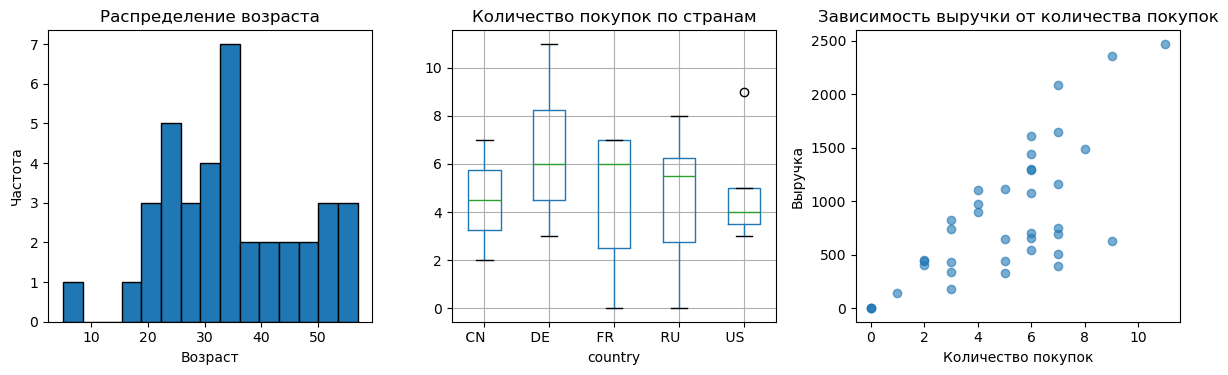

In [25]:
plt.figure(figsize=(12, 4))

# Гистограмма возраста
plt.subplot(1, 3, 1)
plt.hist(df_clean['age'], bins=15, edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')

# Боксплот покупок по странам
plt.subplot(1, 3, 2)
df_clean.boxplot(column='purchases', by='country', ax=plt.gca())
plt.title('Количество покупок по странам')
plt.suptitle('')

# Scatter plot
plt.subplot(1, 3, 3)
plt.scatter(df_clean['purchases'], df_clean['revenue'], alpha=0.6)
plt.title('Зависимость выручки от количества покупок')
plt.xlabel('Количество покупок')
plt.ylabel('Выручка')

plt.tight_layout()
plt.savefig('figures/visualizations.png', dpi=300)
plt.show()

# Описание графиков
* Гистограмма возраста показывает нормальное распределение с пиком в районе 30 лет.
* Боксплот выявил различия в распределении покупок между странами.
* Scatter plot демонстрирует положительную корреляцию между количеством покупок и выручкой.